In [1]:
from __future__ import division, print_function, unicode_literals

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


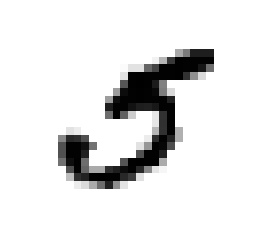

5.0

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
    interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96195, 0.9689 , 0.9599 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90805, 0.9117 , 0.9092 ])

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53103,  1476],
       [ 1262,  4159]])

In [15]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7380656610470275
0.7672016233167313


In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7523516642547035

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([75981.94575191])

In [18]:
threshold = 0
y_some_digit_threshold = (y_scores > threshold)
y_some_digit_threshold

array([ True])

In [19]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

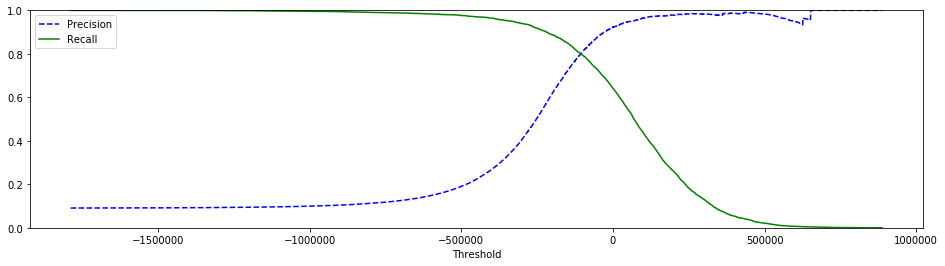

In [20]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
   
plt.figure(figsize=(16, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

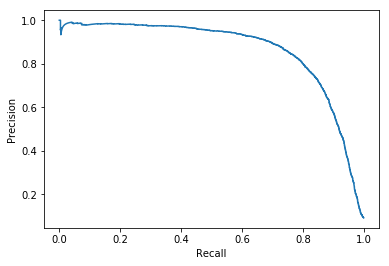

In [21]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [22]:
y_train_pred_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9517775431186202
0.4988009592326139


In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

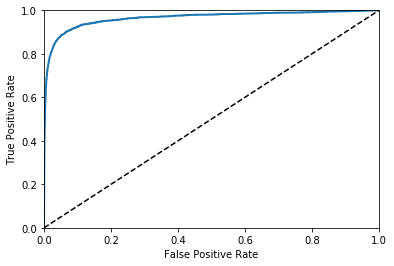

In [25]:
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9649676839630918

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [28]:
y_probas_forest

array([[0.8, 0.2],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1]])

In [29]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

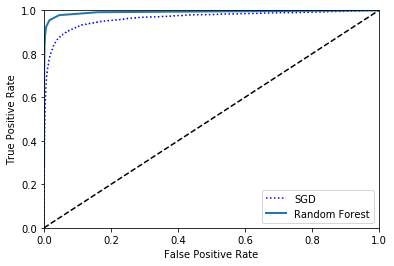

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921845153713525

In [32]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.984347442680776

In [33]:
recall_score(y_train_5, y_train_pred_forest)

0.823648773289061

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -69101.60216252, -471888.09776125, -376855.9373192 ,
        -187902.10473975, -420295.56084325,   32888.73598996,
        -742074.40493641, -309727.14492828, -804577.64814578,
        -516883.69629151]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier())
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [40]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0.1, 0. ]])

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87777445, 0.85314266, 0.86748012])

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91031794, 0.91064553, 0.90778617])

In [43]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9395121 , 0.94014701, 0.94079112])

In [44]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.94111178, 0.93899695, 0.94164125])

In [45]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5793,    3,   17,   12,    9,   16,   32,    3,   33,    5],
       [   3, 6619,   37,   19,   13,   10,    7,   14,   13,    7],
       [  49,   32, 5616,   49,   39,   15,   31,   56,   56,   15],
       [  18,   26,  134, 5642,    6,  116,    7,   49,   91,   42],
       [  18,   15,   30,   12, 5533,   10,   38,   23,   29,  134],
       [  40,   14,   29,  189,   33, 4971,   42,    9,   53,   41],
       [  49,   14,   22,    8,   33,   64, 5702,    0,   26,    0],
       [  10,   32,  102,   27,   59,    5,    3, 5929,   17,   81],
       [  36,   49,   78,  153,   51,  113,   38,   18, 5232,   83],
       [  25,   26,   30,   91,  181,   45,    7,   81,   53, 5410]])

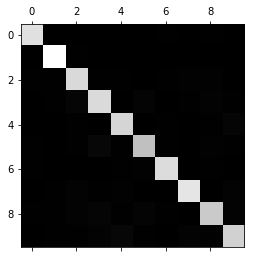

In [55]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

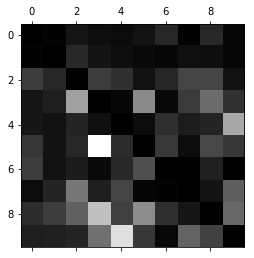

In [56]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

In [65]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

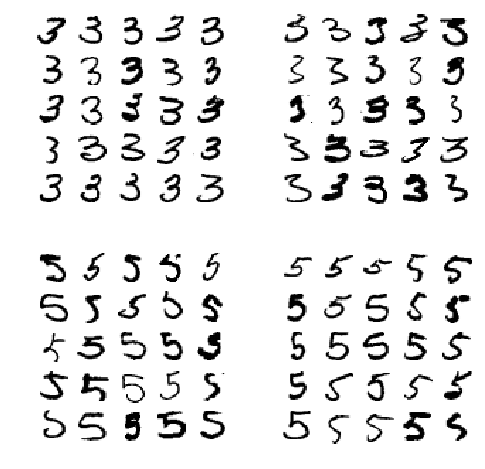

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()